Classes: ['ball', 'healthy', 'inner', 'outer']
Total samples: 1180
Train samples: 944, Val samples: 236
Epoch [1/25] Train Loss: 0.9434 | Train Acc: 58.58% || Val Loss: 0.5745 | Val Acc: 77.54%
⭐ New best model saved with Val Acc: 77.54%
Epoch [2/25] Train Loss: 0.6738 | Train Acc: 71.93% || Val Loss: 0.4075 | Val Acc: 86.02%
⭐ New best model saved with Val Acc: 86.02%
Epoch [3/25] Train Loss: 0.5536 | Train Acc: 78.07% || Val Loss: 0.3774 | Val Acc: 83.47%
Epoch [4/25] Train Loss: 0.4631 | Train Acc: 81.36% || Val Loss: 0.3705 | Val Acc: 86.86%
⭐ New best model saved with Val Acc: 86.86%
Epoch [5/25] Train Loss: 0.4623 | Train Acc: 81.99% || Val Loss: 0.3688 | Val Acc: 88.98%
⭐ New best model saved with Val Acc: 88.98%
Epoch [6/25] Train Loss: 0.3891 | Train Acc: 84.22% || Val Loss: 0.1699 | Val Acc: 92.37%
⭐ New best model saved with Val Acc: 92.37%
Epoch [7/25] Train Loss: 0.3680 | Train Acc: 85.49% || Val Loss: 0.2155 | Val Acc: 93.22%
⭐ New best model saved with Val Acc: 93.22%
Ep

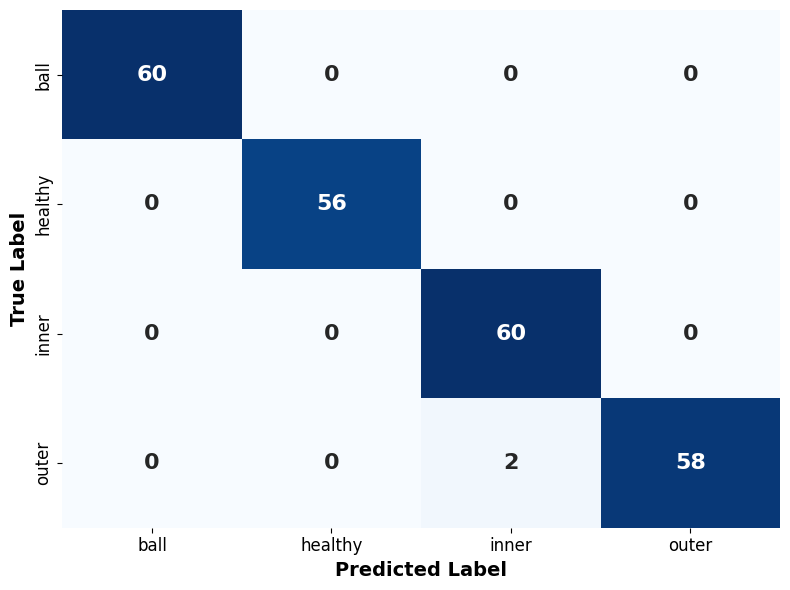

✅ Confusion matrix saved at: F:\NeuTech\new_results\Comparison\CWRU\proposed\cm_val.png


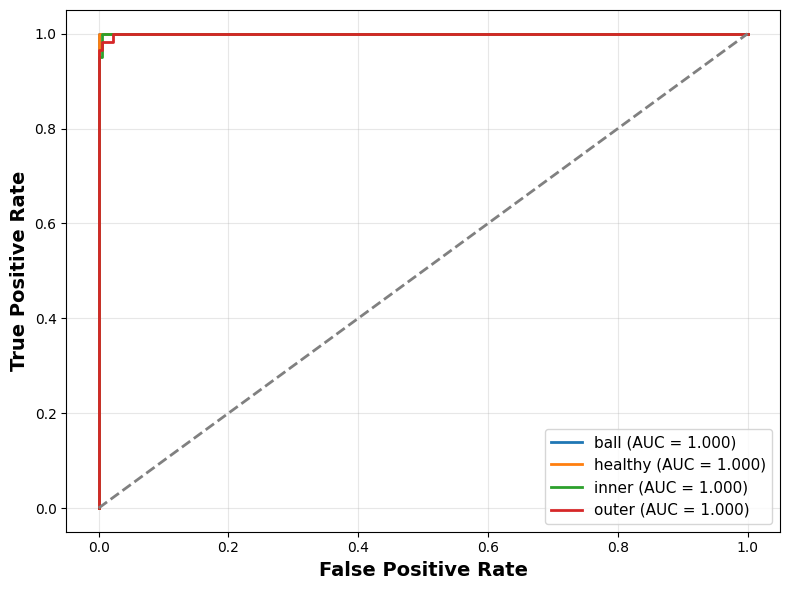

✅ ROC curves saved at: F:\NeuTech\new_results\Comparison\CWRU\proposed\roc_val.png


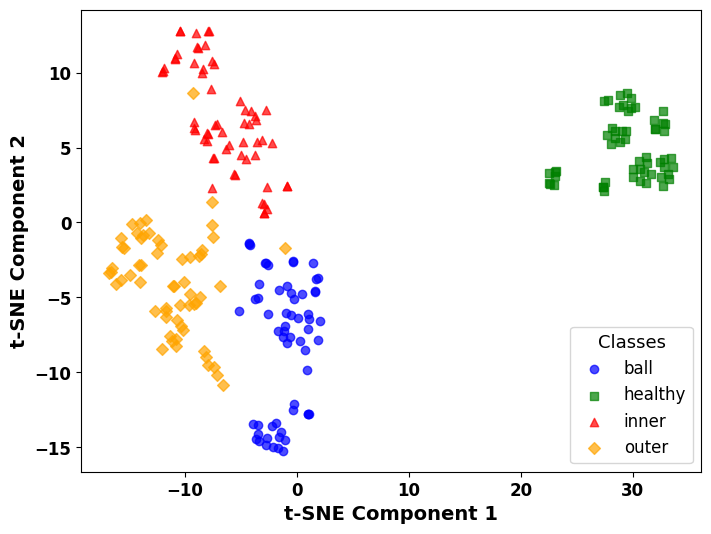

✅ t-SNE plot saved at: F:\NeuTech\new_results\Comparison\CWRU\proposed\tsne_features_cnn.png
✅ All done.


In [4]:
import os
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

# =========================================================
# CONFIG
# =========================================================
class CFG:
    data_root = r"F:\NeuTech\CWT_balanced"                       # <-- your dataset root
    output_dir = r"F:\NeuTech\new_results\Comparison\CWRU\proposed" # <-- your output dir
    batch_size  = 32
    num_workers = 4
    num_epochs  = 25
    lr          = 1e-4
    seed        = 42
    val_ratio   = 0.2                                      # 80% train / 20% val
    device      = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG()
os.makedirs(cfg.output_dir, exist_ok=True)

# =========================================================
# SEED EVERYTHING
# =========================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)

# =========================================================
# DATASETS & STRATIFIED TRAIN/VAL SPLIT
# =========================================================
# Base dataset without transform (for indexing, labels)
base_dataset = datasets.ImageFolder(root=cfg.data_root)

class_names = base_dataset.classes  # ['ball', 'healthy', 'inner', 'outer']
num_classes = len(class_names)
print("Classes:", class_names)

# Stratified split: per-class indices -> train/val
label_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(base_dataset.samples):
    label_to_indices[label].append(idx)

train_indices = []
val_indices   = []

for label, idxs in label_to_indices.items():
    idxs = np.array(idxs)
    np.random.shuffle(idxs)
    n_total = len(idxs)
    n_val   = int(n_total * cfg.val_ratio)
    # Ensure at least 1 val sample per class
    n_val   = max(1, n_val)

    val_idx   = idxs[:n_val]
    train_idx = idxs[n_val:]

    val_indices.extend(val_idx.tolist())
    train_indices.extend(train_idx.tolist())

# Shuffle final index lists
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

print(f"Total samples: {len(base_dataset)}")
print(f"Train samples: {len(train_indices)}, Val samples: {len(val_indices)}")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# Two copies of ImageFolder with different transforms,
# then restrict them by Subset with the same indices.
train_dataset_full = datasets.ImageFolder(root=cfg.data_root, transform=train_transform)
val_dataset_full   = datasets.ImageFolder(root=cfg.data_root, transform=val_transform)

train_dataset = Subset(train_dataset_full, train_indices)
val_dataset   = Subset(val_dataset_full,   val_indices)

train_loader = DataLoader(
    train_dataset, batch_size=cfg.batch_size,
    shuffle=True, num_workers=cfg.num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=cfg.batch_size,
    shuffle=False, num_workers=cfg.num_workers, pin_memory=True
)

# =========================================================
# MODEL: RESNET18 CNN
# =========================================================
def build_model(num_classes, pretrained=True):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

model = build_model(num_classes=num_classes, pretrained=True)
model = model.to(cfg.device)

# =========================================================
# TRAINING UTILITIES
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss    += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total           += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_corrects / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        preds   = outputs.argmax(dim=1)

        running_loss    += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total           += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = running_corrects / total
    return epoch_loss, epoch_acc

# =========================================================
# TRAIN LOOP WITH BEST-MODEL SAVING
# =========================================================
best_val_acc   = 0.0
best_model_path = os.path.join(cfg.output_dir, "best_cnn_resnet18.pth")

for epoch in range(1, cfg.num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, cfg.device)
    val_loss, val_acc     = evaluate(model, val_loader, criterion, cfg.device)

    print(f"Epoch [{epoch}/{cfg.num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% "
          f"|| Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"⭐ New best model saved with Val Acc: {best_val_acc*100:.2f}%")

print(f"\nBest Val Acc: {best_val_acc*100:.2f}%")
print("Best model path:", best_model_path)

# Load best before metrics/plots
model.load_state_dict(torch.load(best_model_path, map_location=cfg.device))

# =========================================================
# HELPER: FORWARD TO LOGITS (GENERIC CNN)
# =========================================================
@torch.no_grad()
def _forward_logits(model, x, device):
    x = x.to(device)
    logits = model(x)
    return logits

# =========================================================
# 1) CONFUSION MATRIX
# =========================================================
@torch.no_grad()
def plot_confusion_matrix(model, dataloader, class_names, device, save_path="confusion_matrix.png"):
    model.eval()
    all_labels, all_preds = [], []

    for batch in dataloader:
        if isinstance(batch, dict):
            x = batch["pixel_values"]
            y = batch["labels"]
        else:
            x, y = batch

        y = y.to(device)
        logits = _forward_logits(model, x, device)
        preds  = logits.argmax(dim=1)

        all_labels.extend(y.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

    cm = confusion_matrix(all_labels, all_preds)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={"size": 16, "fontweight": "bold"})
    plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.show()
    print(f"✅ Confusion matrix saved at: {save_path}")

# =========================================================
# 2) ROC CURVES (ONE-VS-REST)
# =========================================================
@torch.no_grad()
def plot_roc_curves(model, dataloader, class_names, device, save_path="roc_curves.png"):
    model.eval()
    num_classes = len(class_names)

    all_labels, all_probs = [], []

    for batch in dataloader:
        if isinstance(batch, dict):
            x = batch["pixel_values"]
            y = batch["labels"]
        else:
            x, y = batch

        logits = _forward_logits(model, x, device)
        probs  = torch.softmax(logits, dim=1)

        all_labels.extend(y.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)
    y_bin = label_binarize(all_labels, classes=list(range(num_classes)))  # [N, C]

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    # Chance line
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)
    plt.show()
    print(f"✅ ROC curves saved at: {save_path}")

# =========================================================
# 3) t-SNE FEATURE EXTRACTION (CNN)
# =========================================================
@torch.no_grad()
def extract_features(model, dataloader, device):
    """
    Extracts features from the CNN before the final FC layer
    (global average pooled features for ResNet).
    """
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1]).to(device)

    all_features, all_labels = [], []

    for batch in dataloader:
        if isinstance(batch, dict):
            x = batch["pixel_values"]
            y = batch["labels"]
        else:
            x, y = batch

        x = x.to(device)
        y = y.to(device)

        feats = feature_extractor(x)   # [B, C, 1, 1]
        feats = feats.view(feats.size(0), -1)  # [B, C]
        all_features.append(feats.cpu().numpy())
        all_labels.append(y.cpu().numpy())

    features = np.concatenate(all_features, axis=0)
    labels   = np.concatenate(all_labels, axis=0)
    return features, labels

def compute_tsne(features, n_components=2, random_state=42):
    tsne = TSNE(n_components=n_components, random_state=random_state,
                init='pca', perplexity=30)
    return tsne.fit_transform(features)

def plot_tsne(features_tsne, labels, class_names, save_path="tsne_cnn_cwt.png"):
    plt.figure(figsize=(8, 6))

    colors  = ['blue', 'green', 'red', 'orange']
    markers = ['o', 's', '^', 'D']

    for i, (cls, color, marker) in enumerate(zip(class_names, colors, markers)):
        mask = (labels == i)
        plt.scatter(features_tsne[mask, 0], features_tsne[mask, 1],
                    label=cls, color=color, marker=marker, alpha=0.7)

    plt.legend(title="Classes", fontsize=12, title_fontsize=13,
               loc='best', frameon=True)
    plt.xlabel('t-SNE Component 1', fontsize=14, fontweight='bold')
    plt.ylabel('t-SNE Component 2', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=1000)
    plt.show()
    print(f"✅ t-SNE plot saved at: {save_path}")

# =========================================================
# RUN METRICS & PLOTS ON VALIDATION SET
# =========================================================
cm_path   = os.path.join(cfg.output_dir, "cm_val.png")
roc_path  = os.path.join(cfg.output_dir, "roc_val.png")
tsne_path = os.path.join(cfg.output_dir, "tsne_features_cnn.png")

plot_confusion_matrix(model, val_loader, class_names, cfg.device, save_path=cm_path)
plot_roc_curves(model, val_loader, class_names, cfg.device, save_path=roc_path)

features, labels = extract_features(model, val_loader, cfg.device)
features_2d = compute_tsne(features)
plot_tsne(features_2d, labels, class_names, save_path=tsne_path)

print("✅ All done.")
